In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from aae import LitAAE, load_file, preprocessing_adata, scDataset, KFoldAdata

In [2]:
pl.seed_everything(1)

[rank: 0] Global seed set to 1


1

In [3]:
print(torch.cuda.is_available())

True


In [4]:
BATCH_SIZE = 64
NUM_WORKERS = 1
DATA_PATH = '/gpfs/gibbs/project/gerstein/cz357/23spring/2304_AAE/data/'

In [5]:
adata = load_file(name='pbmc-2ctrl-dm-fake4000', data_path=DATA_PATH)
adata

AnnData object with n_obs × n_vars = 17853 × 15488
    obs: 'doublet_label', 'celltype', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'doublet_label_colors'

In [6]:
preprocessing_adata(adata, n_top_genes=3000)

In [7]:
adata

AnnData object with n_obs × n_vars = 17853 × 3000
    obs: 'doublet_label', 'celltype', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'doublet_label_colors', 'log1p', 'hvg'
    layers: 'counts'

In [8]:
scdata = scDataset(adata)

In [9]:
KF = KFoldAdata(scdata, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [10]:
aae = LitAAE([3000, 64, [128, 64], [64, 128], [128, 64]],
             batch_size=BATCH_SIZE,
             batch_norm=True,
             dropout=0.2,
             D_out='Sigmoid'
            )
trainer = pl.Trainer(max_epochs=100, accelerator='auto')

/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorc ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless 

In [158]:
trainer.fit(aae, KF.train_dataloader(4), KF.test_dataloader(4))

/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | encoder       | Encoder       | 396 K 
1 | decoder       | Decoder       | 399 K 
2 | discriminator | Discriminator | 16.6 K
-----------------------------

Training data info:
singlet      9796
generated    3207
doublet      1280
Name: doublet_label, dtype: int64


test data info:
singlet      2465
generated     793
doublet       312
Name: doublet_label, dtype: int64




/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [159]:
if not os.path.isdir('models'):
    os.makedirs('models')

In [160]:
torch.save(aae, 'models/pbmc-2ctrl-dm-fake4000_test3.pth')
torch.save(aae.state_dict(), 'models/pbmc-2ctrl-dm-fake4000_test3_weights.pth')

In [11]:
aae = torch.load('models/pbmc-2ctrl-dm-fake4000_test2.pth')
aae.eval()

LitAAE(
  (encoder): Encoder(
    (hidden_activation): ReLU()
    (hidden): Sequential(
      (0): Linear(in_features=3000, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
    )
    (generate_z): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (hidden_activation): ReLU()
    (hidden): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0

# analysis

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

In [13]:
train_df = pd.DataFrame()
for batch_idx, data in enumerate(KF.train_dataloader(4)):
    df_latent = pd.DataFrame(aae.get_latent(data[0]).detach().numpy())
    df_label = pd.DataFrame(data[1].numpy(), columns=['label'])
    df_merged = pd.concat([df_latent, df_label], axis=1)
    train_df = pd.concat([train_df, df_merged])

Training data info:
singlet      9796
generated    3207
doublet      1280
Name: doublet_label, dtype: int64




In [14]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,-0.784121,-0.050648,-0.200083,-0.505733,-0.298939,0.819010,-0.227936,-0.094384,-1.143707,0.200285,...,-1.889441,-1.731044,0.569804,0.256102,-0.391952,-0.032099,-0.410697,-0.870522,-1.040936,2
1,-0.387946,0.147232,-0.108395,-0.442439,1.199226,0.515848,0.391414,1.273334,-0.693427,-0.251596,...,0.298247,0.221000,0.125712,1.398539,0.647295,-0.003662,-0.532009,0.171764,-0.414289,2
2,-0.969191,-0.470891,-0.491482,-0.171581,-0.219019,0.786490,-0.023958,0.711287,0.222145,0.381343,...,-0.025493,-0.284001,0.198029,0.517886,-0.266491,-0.268818,-0.477826,-0.748011,-0.369356,0
3,-0.458544,0.029920,0.626439,-0.097070,0.887185,0.436988,0.647336,0.815065,0.153546,0.538685,...,-0.142130,0.242431,-0.152208,0.856129,0.064161,0.822219,0.499359,0.176636,-0.347652,1
4,-0.048709,0.009021,-0.795761,0.142418,-0.277015,0.898332,0.094725,-0.329324,-0.901478,0.544479,...,-0.633295,-0.584767,-0.777557,0.119155,0.301321,-0.601297,-0.666587,-0.948634,-1.276316,1


In [15]:
fig_dir = '/gpfs/gibbs/project/gerstein/cz357/23spring/2304_AAE/fig/'

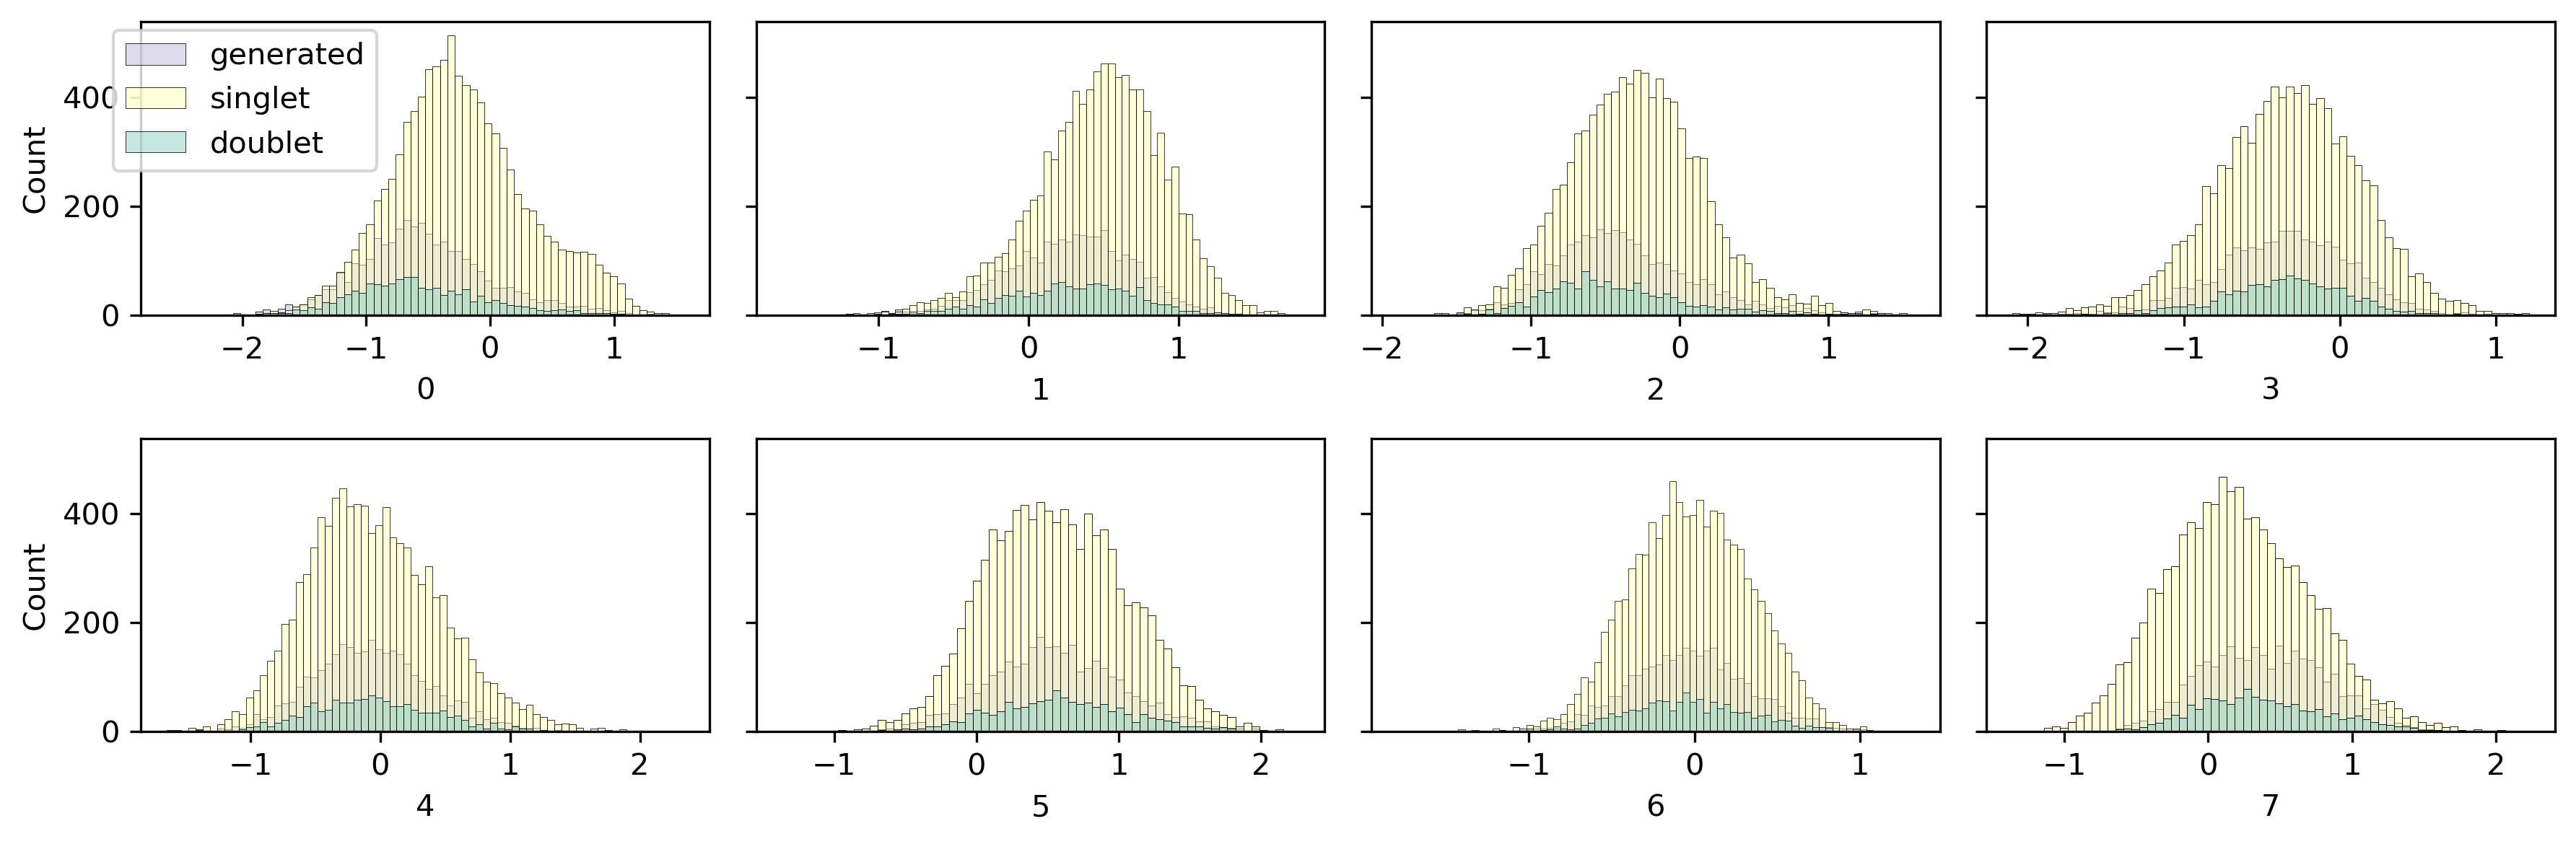

In [16]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 4), dpi=300)
for i in range(8):
    sns.histplot(data=train_df, x=i, hue='label', ax=axs[i // 4, i % 4],
                 palette='Set3', legend=False)
plt.tight_layout()
fig.legend(['generated', 'singlet', 'doublet'], bbox_to_anchor=[0.155, 0.97])
fig.savefig(fig_dir+'3.latent_8.pdf', bbox_inches='tight')
plt.show()

In [17]:
for batch_idx, data in enumerate(KF.train_dataloader(4)):
    test = data[1].numpy()

Training data info:
singlet      9796
generated    3207
doublet      1280
Name: doublet_label, dtype: int64




In [18]:
test

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1])

In [19]:
df_mse = pd.DataFrame()
for batch_idx, data in enumerate(KF.train_dataloader(4)):
    output = aae.forward(data[0]).detach().numpy()
    mse = pd.DataFrame(np.mean(np.square(data[0].numpy() - output), axis=1), columns=['MSE'])
    df_label = pd.DataFrame(data[1].numpy(), columns=['label'])
    mse_label = pd.concat([mse, df_label], axis=1)
    df_mse = pd.concat([df_mse, mse_label])

Training data info:
singlet      9796
generated    3207
doublet      1280
Name: doublet_label, dtype: int64




In [20]:
df_mse.head()

,MSE,label
0,0.133499,1
1,0.140147,1
2,0.108466,2
3,0.091120,0
4,0.132902,1


In [21]:
df_mse[df_mse['label']==0].mean()

MSE      0.124952
label    0.000000
dtype: float64

In [22]:
df_mse[df_mse['label']==1].mean()

MSE      0.123726
label    1.000000
dtype: float64

In [23]:
df_mse[df_mse['label']==2].mean()

MSE      0.13389
label    2.00000
dtype: float64

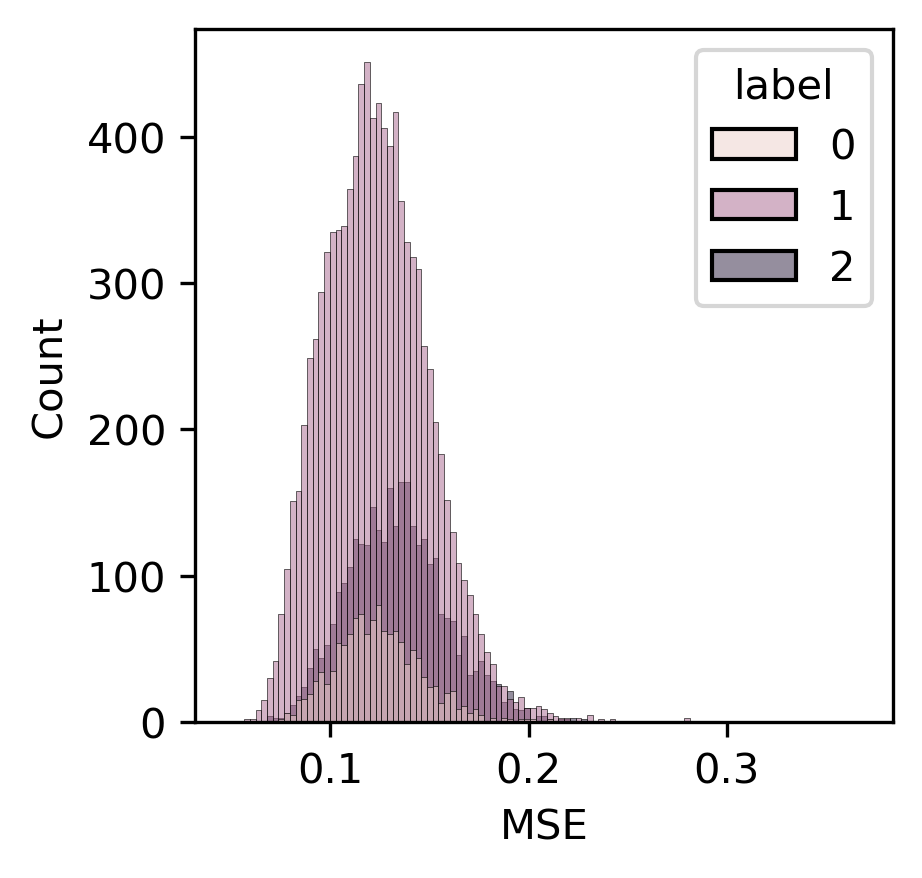

In [24]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
sns.histplot(data=df_mse, x='MSE', hue='label')
plt.show()

In [25]:
all_pred = pd.DataFrame()
for batch_idx, data in enumerate(KF.train_dataloader(4)):
    df_pred = pd.DataFrame(aae.predict(data[0]).detach().numpy())
    df_label = pd.DataFrame(data[1].numpy(), columns=['label'])
    df_merged = pd.concat([df_pred, df_label], axis=1)
    all_pred = pd.concat([all_pred, df_merged])

Training data info:
singlet      9796
generated    3207
doublet      1280
Name: doublet_label, dtype: int64




In [26]:
test_df = pd.DataFrame()
for batch_idx, data in enumerate(KF.test_dataloader(4)):
    df_latent = pd.DataFrame(aae.get_latent(data[0]).detach().numpy())
    df_label = pd.DataFrame(data[1].numpy(), columns=['label'])
    df_merged = pd.concat([df_latent, df_label], axis=1)
    test_df = pd.concat([test_df, df_merged])

test data info:
singlet      2465
generated     793
doublet       312
Name: doublet_label, dtype: int64




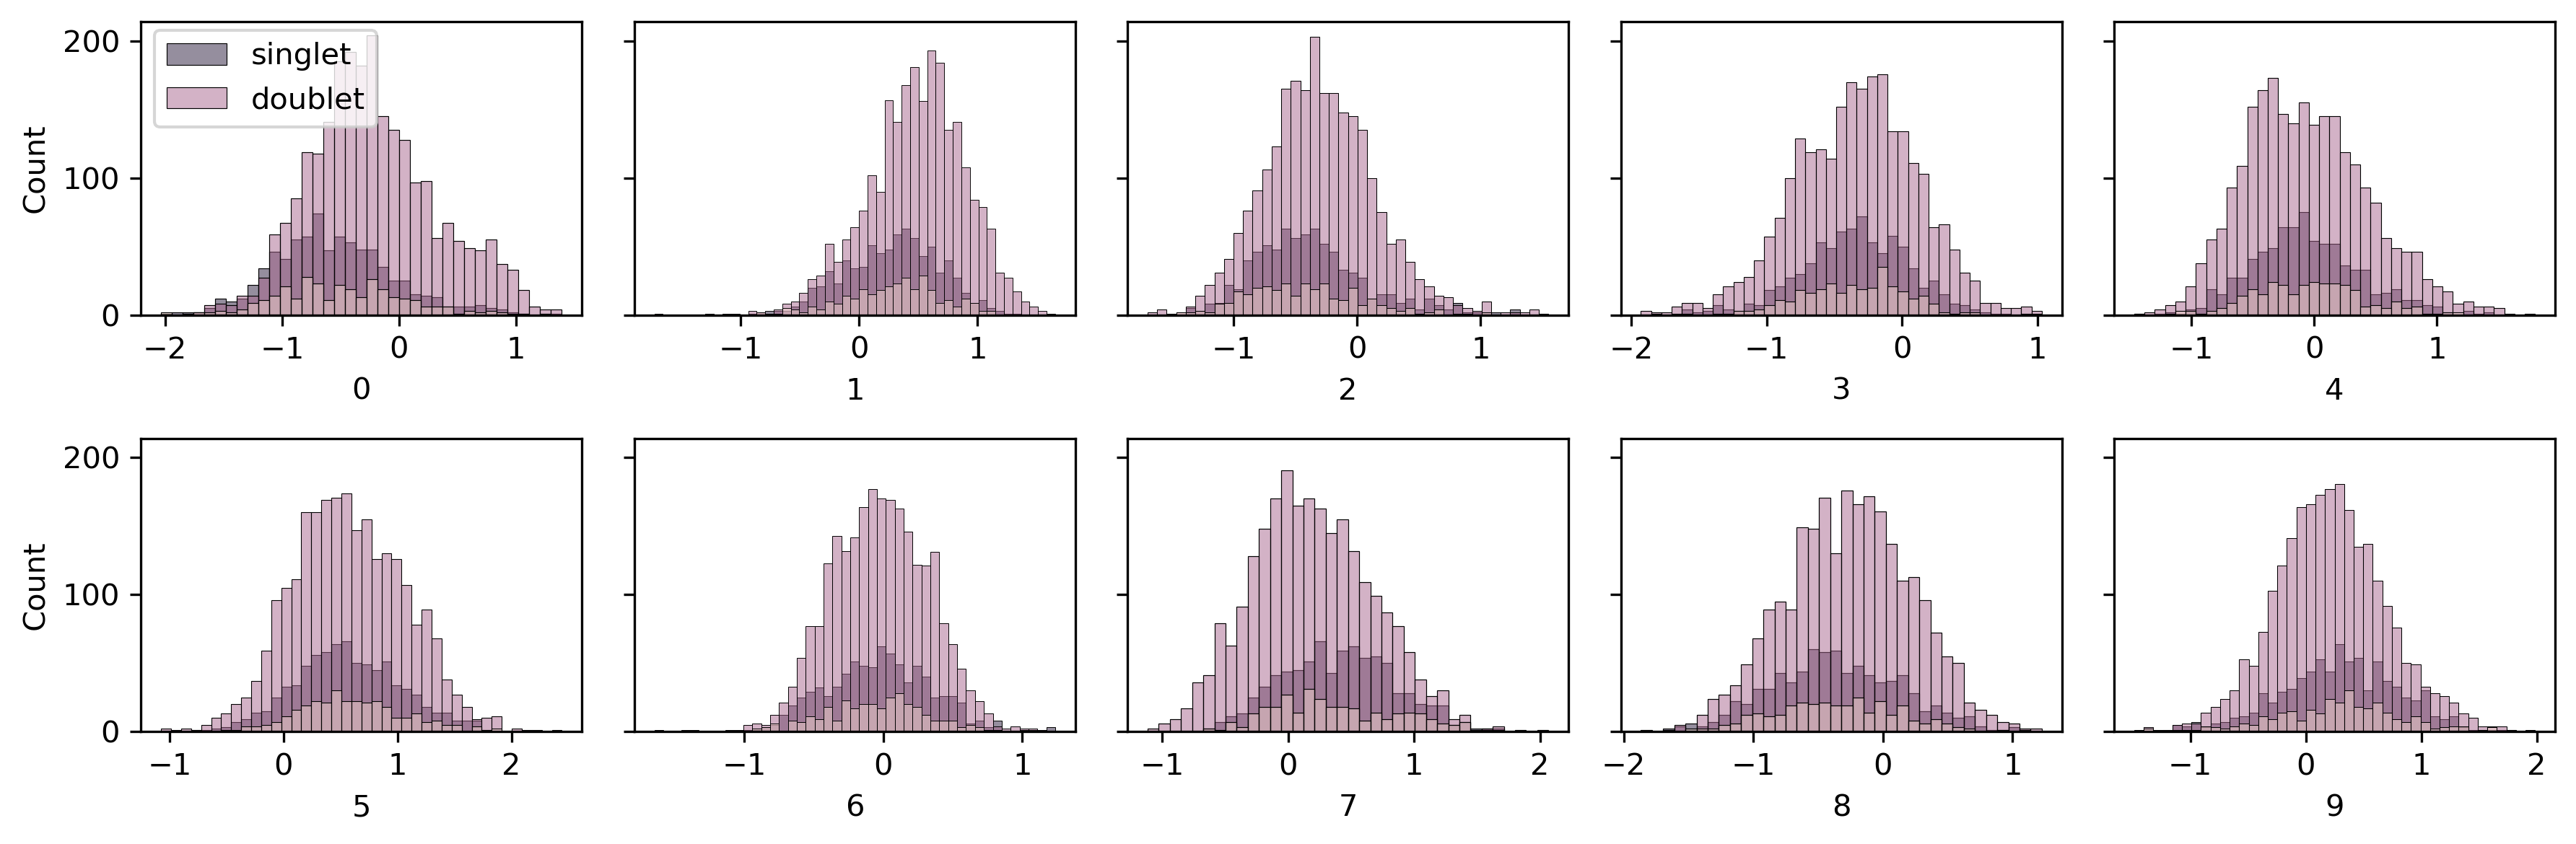

In [27]:
fig, axs = plt.subplots(2, 5, sharey=True, figsize=(12, 4), dpi=300)
for i in range(10):
    sns.histplot(data=test_df, x=i, hue='label', ax=axs[i // 5, i % 5], legend=False)
plt.tight_layout()
fig.legend(['singlet', 'doublet'], bbox_to_anchor=[0.155, 0.97])
plt.show()

In [28]:
df_mse = pd.DataFrame()
for batch_idx, data in enumerate(KF.test_dataloader(4)):
    output = aae.forward(data[0]).detach().numpy()
    mse = pd.DataFrame(np.mean(np.square(data[0].numpy() - output), axis=1), columns=['MSE'])
    df_label = pd.DataFrame(data[1].numpy(), columns=['label'])
    mse_label = pd.concat([mse, df_label], axis=1)
    df_mse = pd.concat([df_mse, mse_label])

test data info:
singlet      2465
generated     793
doublet       312
Name: doublet_label, dtype: int64




In [29]:
df_mse[df_mse['label']==0].mean()

MSE      0.125502
label    0.000000
dtype: float64

In [30]:
df_mse[df_mse['label']==1].mean()

MSE      0.123735
label    1.000000
dtype: float64

In [31]:
df_mse[df_mse['label']==2].mean()

MSE      0.136214
label    2.000000
dtype: float64

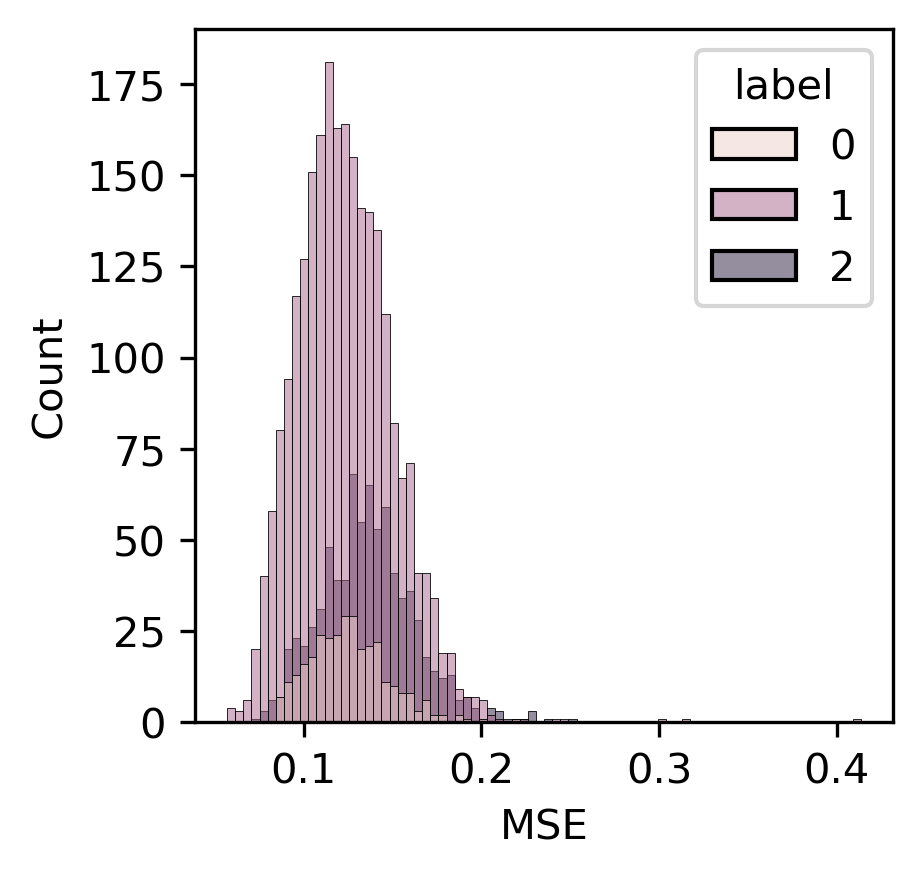

In [32]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
sns.histplot(data=df_mse, x='MSE', hue='label')
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

class Doublet_Classifier(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(Doublet_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.to(self.fc1.weight.dtype)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.binary_cross_entropy(y_pred, y.float())
        self.log('train_loss', loss, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.binary_cross_entropy(y_pred, y.float())
        self.log('test_loss', loss, prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [34]:
train_df['fake_label'] = train_df['label'].map({0: 1, 1: 1, 2: 0})
test_df['fake_label'] = test_df['label'].map({0: 1, 1: 1, 2: 0})

In [35]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,label,fake_label
0,-0.784121,-0.050648,-0.200083,-0.505733,-0.298939,0.819010,-0.227936,-0.094384,-1.143707,0.200285,...,-1.731044,0.569804,0.256102,-0.391952,-0.032099,-0.410697,-0.870522,-1.040936,2,0
1,-0.387946,0.147232,-0.108395,-0.442439,1.199226,0.515848,0.391414,1.273334,-0.693427,-0.251596,...,0.221000,0.125712,1.398539,0.647295,-0.003662,-0.532009,0.171764,-0.414289,2,0
2,-0.969191,-0.470891,-0.491482,-0.171581,-0.219019,0.786490,-0.023958,0.711287,0.222145,0.381343,...,-0.284001,0.198029,0.517886,-0.266491,-0.268818,-0.477826,-0.748011,-0.369356,0,1
3,-0.458544,0.029920,0.626439,-0.097070,0.887185,0.436988,0.647336,0.815065,0.153546,0.538685,...,0.242431,-0.152208,0.856129,0.064161,0.822219,0.499359,0.176636,-0.347652,1,1
4,-0.048709,0.009021,-0.795761,0.142418,-0.277015,0.898332,0.094725,-0.329324,-0.901478,0.544479,...,-0.584767,-0.777557,0.119155,0.301321,-0.601297,-0.666587,-0.948634,-1.276316,1,1


In [36]:
test_df['label'].value_counts()

1    2465
2     793
0     312
Name: label, dtype: int64

In [37]:
test_df['fake_label'].value_counts()

1    2777
0     793
Name: fake_label, dtype: int64

In [38]:
class zDataset(Dataset):
    '''
    latent z dataset for PyTorch dataloader.
    '''
    def __init__(self, data: pd.DataFrame):
        self.data = torch.tensor(data.values)[:, :-2]
        self.labels = torch.tensor(data.values)[:, -1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [39]:
z_train_dataset = zDataset(train_df)

In [40]:
z_train_dataloader = DataLoader(dataset=z_train_dataset, batch_size=64, 
                                num_workers=1, pin_memory=False,
                                shuffle=True)

In [41]:
z_test_dataset = zDataset(test_df)

In [42]:
z_test_dataloader = DataLoader(dataset=z_test_dataset, batch_size=64, 
                               num_workers=1, pin_memory=False,
                               shuffle=False)

In [43]:
doublet_classifier = Doublet_Classifier(64, 16, 1)

In [194]:
trainer = pl.Trainer(max_epochs=50, accelerator='auto')

/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorc ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [195]:
trainer.fit(doublet_classifier, z_train_dataloader, z_test_dataloader)

/gpfs/gibbs/project/gerstein/cz357/conda_envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.0 K 
1 | fc2  | Linear | 17    
--------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estima

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [196]:
torch.save(doublet_classifier, 'models/pbmc-2ctrl-dm-fake4000_clf3.pth')
torch.save(doublet_classifier.state_dict(), 'models/pbmc-2ctrl-dm-fake4000_clf3_weights.pth')

In [44]:
doublet_classifier = torch.load('models/pbmc-2ctrl-dm-fake4000_clf2.pth')
doublet_classifier.eval()

Doublet_Classifier(
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

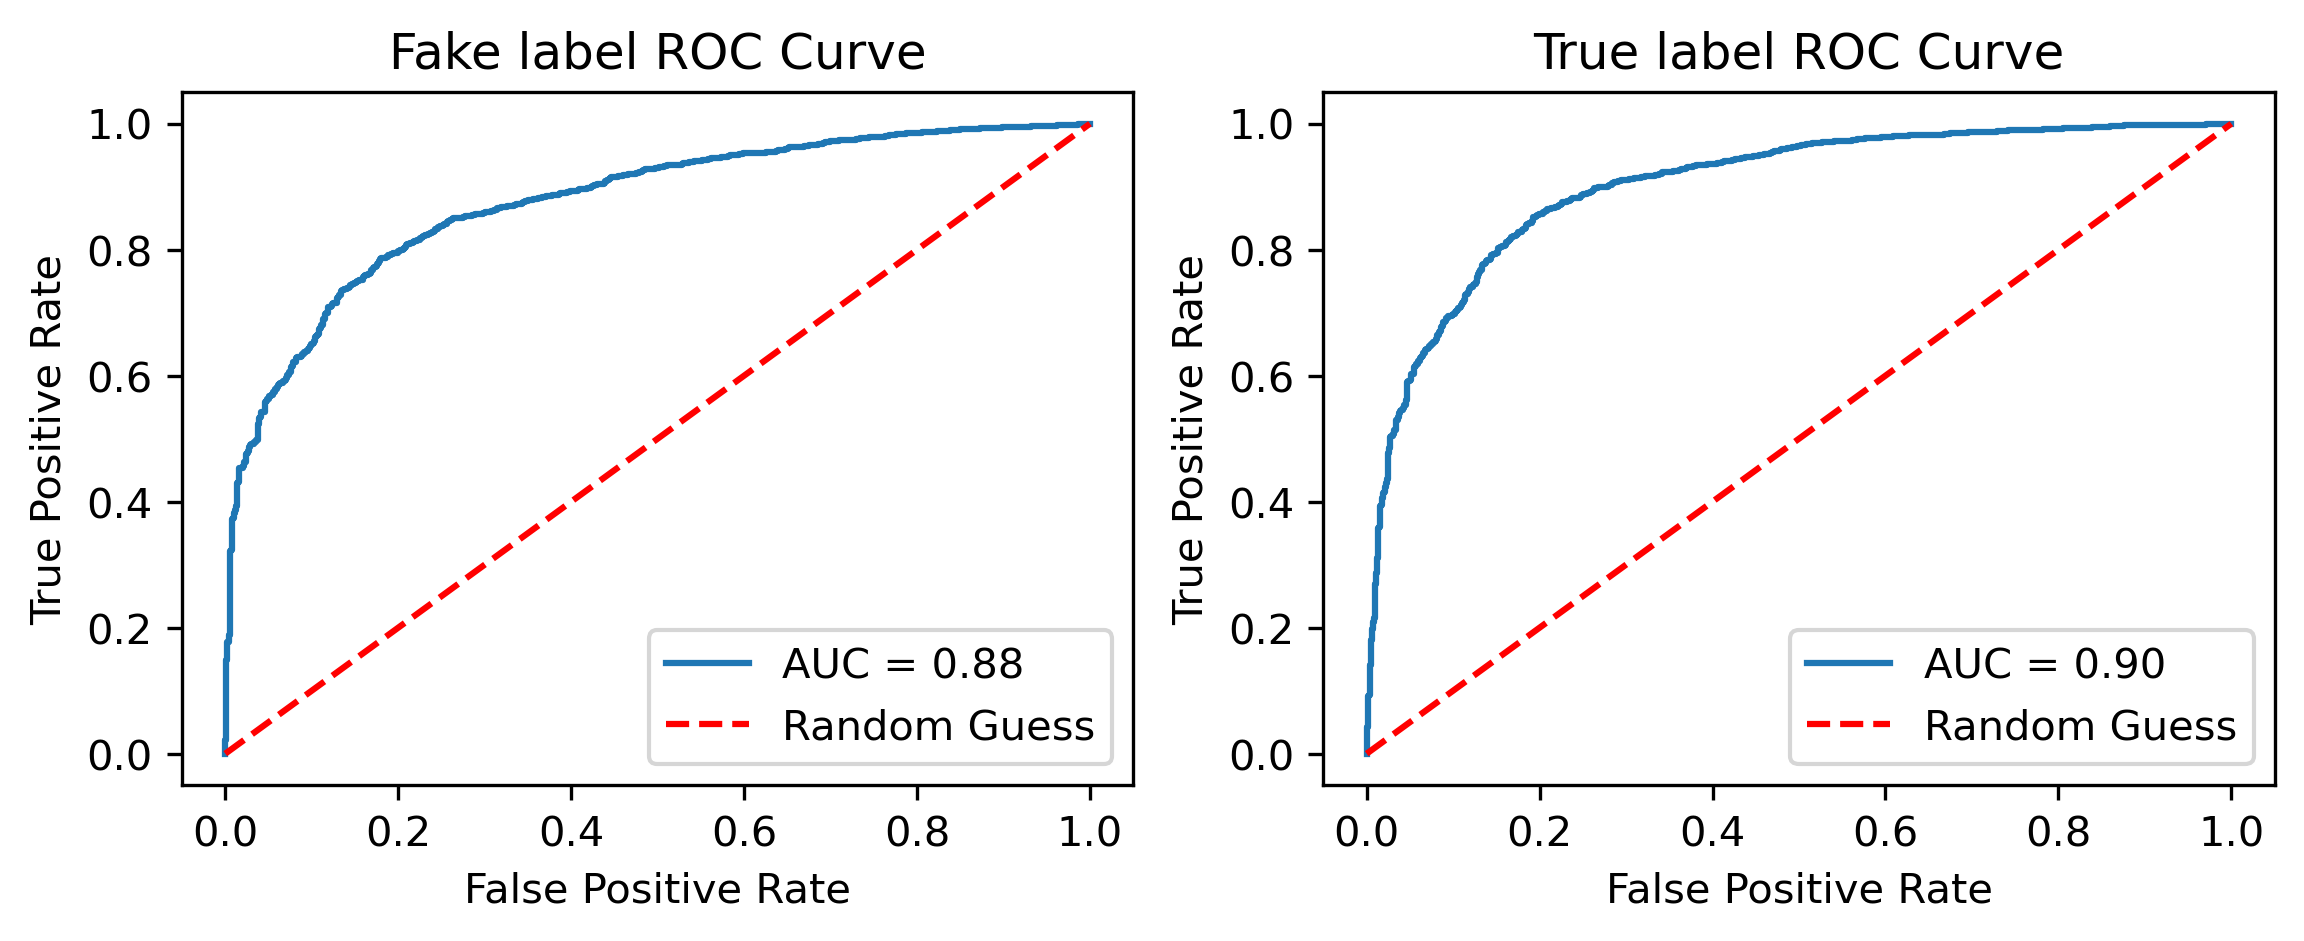

In [57]:
from sklearn.metrics import roc_curve, auc
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
result_df = pd.DataFrame()
for batch_idx, data in enumerate(z_test_dataloader):
    df_latent = pd.DataFrame(doublet_classifier(data[0]).detach().numpy(), columns=['pred'])
    df_label = pd.DataFrame(data[1].numpy(), columns=['label'])
    df_merged = pd.concat([df_latent, df_label], axis=1)
    result_df = pd.concat([result_df, df_merged])
y_true = result_df['label']
y_pred = result_df['pred']
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label='AUC = %0.2f' % auc_score)
axs[0].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Fake label ROC Curve')
axs[0].legend(loc='lower right')
true_result_df = pd.DataFrame()
for batch_idx, data in enumerate(z_test_dataloader):
    df_latent = pd.DataFrame(doublet_classifier(data[0]).detach().numpy(), columns=['pred_label'])
    true_result_df = pd.concat([true_result_df, df_latent])
true_result_df['true_label'] = test_df['label'].map({0:0, 1:1, 2:0})
y_true = true_result_df['true_label']
y_pred = true_result_df['pred_label']
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score = auc(fpr, tpr)
axs[1].plot(fpr, tpr, label='AUC = %0.2f' % auc_score)
axs[1].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('True label ROC Curve')
axs[1].legend(loc='lower right')
fig.savefig(fig_dir+'4.roc_curves.pdf', bbox_inches='tight')
plt.show()